In [85]:
%matplotlib inline 

In [86]:
import os
import json
import re 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.io.json import json_normalize

plt.rcParams['figure.figsize'] = [16, 9]

In [87]:
def CustomParser(data):
    return json.loads(data)


FOLDER = '../results/avulsos/'
regex = re.compile(r'.csv')
folders = set(os.listdir(FOLDER))
folders = filter(lambda i: regex.search(i), folders)
folders = [i for i in folders if regex.search(i)]

df = pd.DataFrame()
# Read csv file
for filename in folders:
    ddf = pd.read_csv(FOLDER + filename, sep=';', converters={'db_parameters': CustomParser, 'model_cfg': CustomParser})
    ddf[sorted(ddf['db_parameters'][0].keys())] = ddf['db_parameters'].apply(pd.Series)
    ddf[sorted(ddf['model_cfg'][0].keys())] = ddf['model_cfg'].apply(pd.Series)
    
    df = pd.concat([df, ddf])

In [88]:
df.shape

(434, 12)

In [89]:
FOLDER = '../results/'
folders = set(os.listdir(FOLDER))

regex = re.compile(r'.csv')
# use only one of the following lines, whichever you prefer
folders = filter(lambda i: not regex.search(i), folders)
folders = [i for i in folders if not regex.search(i)]

folders.remove('_sources')
folders.remove('avulsos')
folders

['results-20181024', 'results-20181105', 'results-old', 'results-20181101']

In [107]:
result = {
    'acc': [],
    'f1': [],
    'db': [],
    'task': [],
    'model': [],
    'db_parameters': []
}

reports = pd.DataFrame()

report_id = 0
for root_folder in folders:
    for fold in os.listdir(FOLDER + root_folder):
        for run_id in os.listdir(FOLDER + root_folder + '/'+fold):
            current_folder = FOLDER + root_folder + '/' + fold + '/' + run_id

            metrics_file = current_folder + '/metrics-test.csv'
            config_file = current_folder + '/config.json'
            report_file = current_folder + '/report-train.csv'

            if not os.path.exists(metrics_file) or not os.path.exists(config_file):
                continue
                
            config_df = pd.read_json(config_file)
#             if config_df['dataset_cfg']['reader'] != "pypagai.preprocessing.dataset_babi.BaBIDataset":
#                 continue

            db = 'babi'
            task = config_df['dataset_cfg']['task']
            model = config_df['model_default_cfg']['model'].split('.')[-1]            
            print(metrics_file, task, model)
            
            if os.path.exists(report_file):
                report_df = pd.read_csv(report_file)
                report_df = report_df.reset_index()
                report_df['dataset'] = db
                report_df['task'] = task
                report_df['model'] = model
                report_df['id'] = report_id
                reports = pd.concat([reports,report_df])
                report_id += 1

            metrics_df = pd.read_csv(metrics_file)
            acc = metrics_df['accuracy'][0]
            f1 = metrics_df['f1_micro'][0]

            result['f1'].append(f1)
            result['db'].append(db)
            result['acc'].append(acc)
            result['task'].append(task)
            result['model'].append(model)
            result['db_parameters'].append(config_file)

new_results = pd.DataFrame(result)
df = pd.concat([df, new_results])

../results/results-20181024/model_default_cfg.model=qa.models.model_rn.ConvStoryRN/6/metrics-test.csv 6 ConvStoryRN
../results/results-20181024/model_default_cfg.model=qa.models.model_rn.ConvStoryRN/1/metrics-test.csv 1 ConvStoryRN
../results/results-20181024/model_default_cfg.model=qa.models.model_rn.ConvStoryRN/20/metrics-test.csv 20 ConvStoryRN
../results/results-20181024/model_default_cfg.model=pypagai.models.model_lstm.EmbedLSTM/10/metrics-test.csv 4 EmbedLSTM
../results/results-20181024/model_default_cfg.model=pypagai.models.model_lstm.EmbedLSTM/9/metrics-test.csv 3 EmbedLSTM
../results/results-20181024/model_default_cfg.model=pypagai.models.model_lstm.EmbedLSTM/21/metrics-test.csv 20 EmbedLSTM
../results/results-20181024/model_default_cfg.model=pypagai.models.model_lstm.EmbedLSTM/18/metrics-test.csv 17 EmbedLSTM
../results/results-20181024/model_default_cfg.model=pypagai.models.model_lstm.EmbedLSTM/1/metrics-test.csv 1 EmbedLSTM
../results/results-20181024/model_default_cfg.mode

../results/results-20181105/model_default_cfg.model=pypagai.models.model_rnn.RNNModel/18/metrics-test.csv 18 RNNModel
../results/results-20181105/model_default_cfg.model=pypagai.models.model_rnn.RNNModel/1/metrics-test.csv 1 RNNModel
../results/results-20181105/model_default_cfg.model=pypagai.models.model_rnn.RNNModel/15/metrics-test.csv 15 RNNModel
../results/results-20181105/model_default_cfg.model=pypagai.models.model_rnn.RNNModel/20/metrics-test.csv 20 RNNModel
../results/results-20181105/model_default_cfg.model=pypagai.models.model_rnn.RNNModel/3/metrics-test.csv 3 RNNModel
../results/results-20181105/model_default_cfg.model=pypagai.models.model_rnn.RNNModel/11/metrics-test.csv 11 RNNModel
../results/results-20181105/model_default_cfg.model=pypagai.models.model_rnn.RNNModel/17/metrics-test.csv 17 RNNModel
../results/results-20181105/model_default_cfg.model=pypagai.models.model_rnn.RNNModel/13/metrics-test.csv 13 RNNModel
../results/results-20181105/model_default_cfg.model=pypagai.

../results/results-old/model_cfg.model=pypagai.models.model_lstm.EmbedLSTM_2/16/metrics-test.csv 16 SimpleLSTM
../results/results-old/model_cfg.model=pypagai.models.model_lstm.EmbedLSTM_2/19/metrics-test.csv 19 SimpleLSTM
../results/results-old/model_cfg.model=pypagai.models.model_lstm.EmbedLSTM_2/5/metrics-test.csv 5 SimpleLSTM
../results/results-old/model_cfg.model=pypagai.models.model_lstm.EmbedLSTM_2/4/metrics-test.csv 4 SimpleLSTM
../results/results-old/model_cfg.model=pypagai.models.model_lstm.EmbedLSTM_2/14/metrics-test.csv 14 SimpleLSTM
../results/results-old/model_cfg.model=pypagai.models.model_lstm.EmbedLSTM_2/12/metrics-test.csv 12 SimpleLSTM
../results/results-old/model_cfg.model=pypagai.models.model_n2nmemory.N2NMemory_2/6/metrics-test.csv 6 SimpleLSTM
../results/results-old/model_cfg.model=pypagai.models.model_n2nmemory.N2NMemory_2/10/metrics-test.csv 10 SimpleLSTM
../results/results-old/model_cfg.model=pypagai.models.model_n2nmemory.N2NMemory_2/9/metrics-test.csv 9 Simpl

../results/results-old/model_cfg.model=pypagai.models.model_encoder.EncoderModel_2/2/metrics-test.csv 2 SimpleLSTM
../results/results-old/model_cfg.model=pypagai.models.model_encoder.EncoderModel_2/8/metrics-test.csv 8 SimpleLSTM
../results/results-old/model_cfg.model=pypagai.models.model_encoder.EncoderModel_2/7/metrics-test.csv 7 SimpleLSTM
../results/results-old/model_cfg.model=pypagai.models.model_encoder.EncoderModel_2/16/metrics-test.csv 16 SimpleLSTM
../results/results-old/model_cfg.model=pypagai.models.model_encoder.EncoderModel_2/19/metrics-test.csv 19 SimpleLSTM
../results/results-old/model_cfg.model=pypagai.models.model_encoder.EncoderModel_2/5/metrics-test.csv 5 SimpleLSTM
../results/results-old/model_cfg.model=pypagai.models.model_encoder.EncoderModel_2/4/metrics-test.csv 4 SimpleLSTM
../results/results-old/model_cfg.model=pypagai.models.model_encoder.EncoderModel_2/14/metrics-test.csv 14 SimpleLSTM
../results/results-old/model_cfg.model=pypagai.models.model_encoder.Encode

../results/results-old/model_cfg.model=pypagai.models.model_encoder.EncoderModel/12/metrics-test.csv 12 SimpleLSTM
../results/results-old/model_default_cfg.model=qa.models.model_rn.ConvRN/1/metrics-test.csv 1 ConvRN
../results/results-old/test/15/metrics-test.csv 9 RNNoLSTM
../results/results-old/test/13/metrics-test.csv 1 RNNoLSTM
../results/results-old/rn/1/metrics-test.csv 1 RN
../results/results-old/rn/3/metrics-test.csv 1 RN
../results/results-old/rn/2/metrics-test.csv 1 RN
../results/results-old/rn/5/metrics-test.csv 1 RN
../results/results-old/rn/4/metrics-test.csv 1 RN
../results/results-old/lstm/1/metrics-test.csv 1 SimpleLSTM
../results/results-old/lstm/2/metrics-test.csv 1 SimpleLSTM
../results/results-old/model_default_cfg.model=pypagai.models.model_n2nmemory.N2NMemory/6/metrics-test.csv 6 N2NMemory
../results/results-old/model_default_cfg.model=pypagai.models.model_n2nmemory.N2NMemory/10/metrics-test.csv 10 N2NMemory
../results/results-old/model_default_cfg.model=pypagai.m

In [105]:
df[(df['model'] == 'RN') & (df['task'] == 2)]

,__doc__,acc,db,db_parameters,f1,model,model_cfg,parser,reader,size,strip_sentences,task


model,ConvInputsRN,ConvQueryRN,ConvRN,ConvStoryRN,DeepN2NMemory,EmbedLSTM,EncoderModel,N2NMemory,RN,RNNModel,RNNoLSTM,SimpleLSTM
task,,,,,,,,,,,,
1,0.456,0.477,0.157,0.911,0.963,0.979,0.349,0.953,0.819,1.000,0.813,0.504
2,0.354,NaN,NaN,NaN,0.325,0.445,0.370,0.281,0.488,0.439,NaN,0.190
3,NaN,NaN,NaN,NaN,0.251,0.534,0.310,0.242,0.417,0.405,NaN,0.207
4,NaN,NaN,NaN,NaN,1.000,1.000,0.572,1.000,1.000,1.000,NaN,0.279
5,NaN,NaN,NaN,NaN,0.826,0.990,0.313,0.869,0.995,0.990,NaN,0.344
6,NaN,NaN,NaN,0.497,0.972,0.679,0.527,0.995,0.883,0.819,NaN,0.636
7,NaN,NaN,NaN,NaN,0.904,0.811,0.764,0.879,0.895,0.998,NaN,0.693
8,NaN,NaN,NaN,NaN,0.802,0.769,0.740,0.804,0.827,0.997,NaN,0.539
9,NaN,NaN,NaN,NaN,0.962,0.626,0.585,0.959,0.841,1.000,0.827,0.655


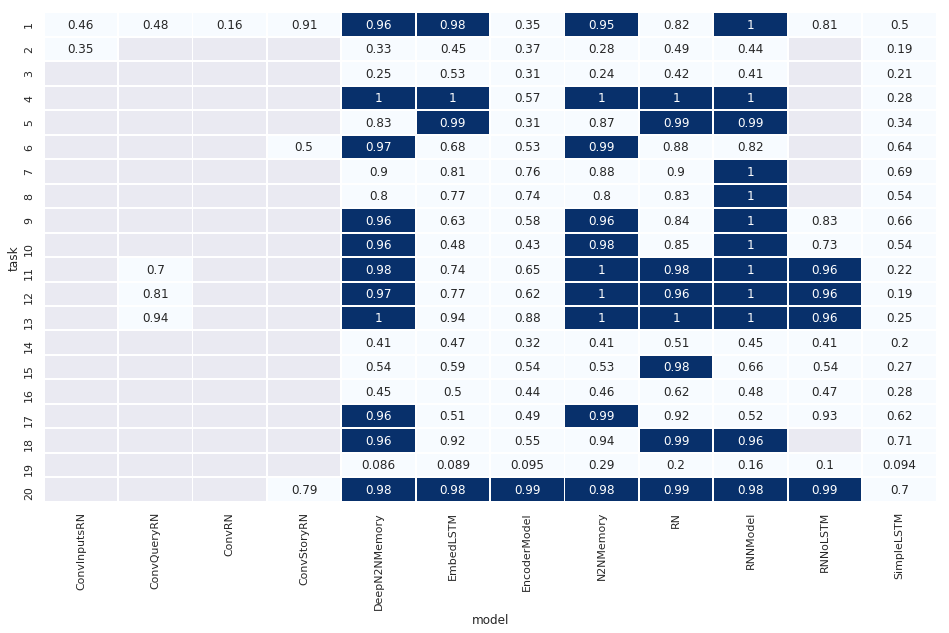

In [108]:
# Show best result of each model for each babi task
# model_list = ['ConvInputsRN','ConvQueryRN','ConvRN','ConvStoryRN','EmbedLSTM','EncoderModel','RNNModel','RNNoLSTM','SimpleLSTM']

ddf = df[df['db'] == 'babi']
# ddf = ddf[~(ddf['model'].isin(model_list))]
ddf = ddf.groupby(['db', 'model', 'task'])
ddf = ddf.max()
ddf = ddf.reset_index()
pivot = ddf[['model', 'acc', 'task']].pivot('task', 'model')
pivot = pivot['acc']

plt.figure(figsize = (16,9))
sns.heatmap(pivot, cmap="Blues", linewidths=1, annot=True, cbar=False, vmin=0.949, vmax=0.95)
pivot

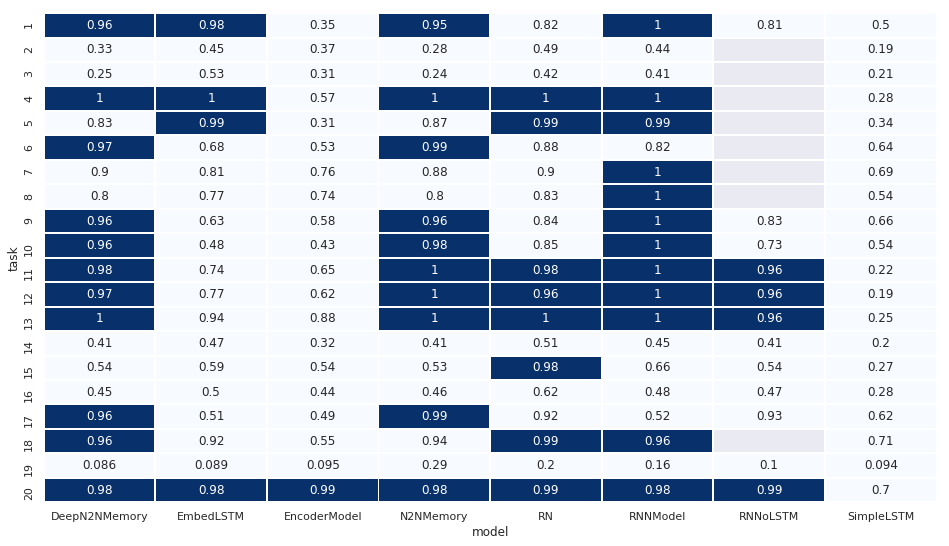

In [109]:
# Show best result of each model for each babi task
model_list = ['ConvInputsRN','ConvQueryRN','ConvRN','ConvStoryRN',]

ddf = df[df['db'] == 'babi']
ddf = ddf[~(ddf['model'].isin(model_list))]
ddf = ddf.groupby(['db', 'model', 'task'])
ddf = ddf.max()
ddf = ddf.reset_index()
pivot = ddf[['model', 'acc', 'task']].pivot('task', 'model')
pivot = pivot['acc']

plt.figure(figsize = (16,9))
sns.heatmap(pivot, cmap="Blues", linewidths=1, annot=True, cbar=False, vmin=0.949, vmax=0.95)

# Epoch evolution

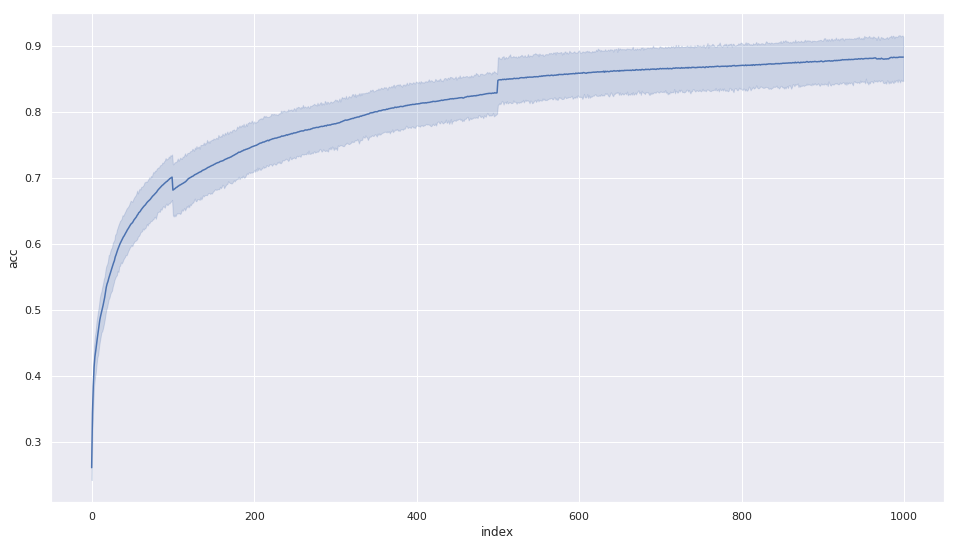

In [110]:
import seaborn as sns
sns.set(style="darkgrid")

# Plot the responses for different events and regions
sns.lineplot(x="index", y="acc", data=reports)

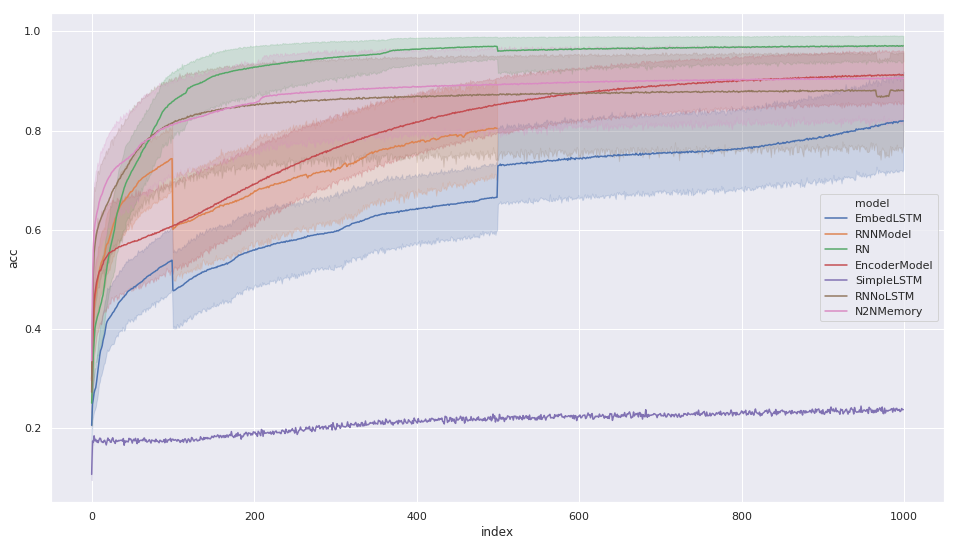

In [111]:
sns.lineplot(x="index", y="acc", hue='model', data=reports[~reports['model'].isin(model_list)])

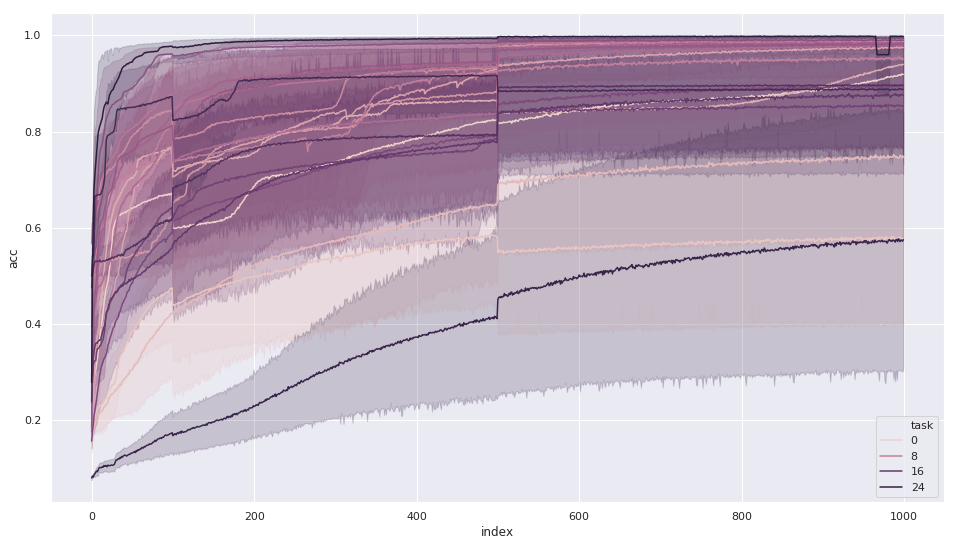

In [114]:
sns.lineplot(x="index", y="acc", hue='task', data=reports[~reports['model'].isin(model_list)])

In [113]:
reports['task'] = reports['task'].astype(int)
reports['task'].unique()

array([ 6,  1, 20,  4,  3, 17, 14, 19, 16, 12,  2, 15, 18,  5, 13, 11, 10,
        9,  8,  7])